In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import numpy as np
# variable contribution
from tsquared import HotellingT2, MYTDecomposition
from xgboost import XGBRegressor
from unravel import *
#information gain
#from sklearn.feature_selection import mutual_info_classif
# Bayesian
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch, BicScore, TreeSearch
from pgmpy.models import BayesianNetwork
from sklearn.preprocessing import StandardScaler


No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
import pyreadr
train_normal_path = 'TEP2017R/TEP_FaultFree_Training.RData'
train_faulty_path =  'TEP2017R/TEP_Faulty_Training.RData'
 
test_normal_path = 'TEP2017R/TEP_FaultFree_Testing.RData'
test_faulty_path = 'TEP2017R/TEP_Faulty_Testing.RData'
 
train_normal = pyreadr.read_r(train_normal_path)['fault_free_training']
train_faulty = pyreadr.read_r(train_faulty_path)['faulty_training']
test_normal = pyreadr.read_r(test_normal_path)['fault_free_testing']
test_faulty = pyreadr.read_r(test_faulty_path)['faulty_testing']

In [3]:
# TEP truths
faultToRoot = {1:'xmeas_4', 4:'xmeas_9', 5:'xmeas_22', 6:'xmeas_1', 11:'xmeas_21', 12:'xmeas_11', 14:'xmeas_9', 15:'xmeas_11'}
faultToVariables = {1:['xmeas_1', 'xmeas_4', 'xmeas_18', 'xmeas_21', 'xmeas_25', 'xmeas_26'],
                    14:['xmeas_9', 'xmeas_11', 'xmeas_21', 'xmeas_32']}
reactor = ['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
           'xmeas_20','xmeas_21']
seperator = ['xmeas_7', 'xmeas_20', 'xmeas_21', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_22']
stripper = ['xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_22', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 
           'xmeas_19', 'xmeas_4', 'xmeas_5']

In [4]:
# only keep continuous variables, xmeas_1 - xmeas_22
df_train_normal = train_normal[train_normal.simulationRun==1].iloc[:,3:25]
df_train_faulty = train_faulty[(train_faulty.simulationRun==1) & (train_faulty.faultNumber==1)].iloc[:,3:25]
df_test_normal = test_normal[test_normal.simulationRun==1].iloc[:,3:25]
df_train_normal.head()
kFeatures = len(df_train_normal.columns)
feature_list = list(df_train_normal.columns)

ss = StandardScaler().set_output(transform="pandas")
ss_df_train_normal = ss.fit_transform(df_train_normal)

In [17]:
# TODO: use AIC and BIC, maybe limit to max 2 outedge
'''
Calculate 
# p, q: model order/ number of lags, T: total number of observations
# F(p, T - p - q - 1) at 5%, F(4, 250000 - 4 - 4 - 1)
threshold = f.ppf(1 - 0.05, max_lag, 250000)
print(threshold)

F_statistics = result[max_lag][0]['ssr_ftest'][0]
print(F_statistics)
'''

from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import f
# this does not work with continuous variable directly
from pyinform.transferentropy import transfer_entropy

def grangerCausalityTable(df, lag = 4):
    kFeatures = len(df.columns)
    # if prob < 0.05, it rejects the null hypothesis and indicate the variable in the row has influence has influence
    # on the variable in column
    GCTable = [[0 for i in range(kFeatures)] for j in range(kFeatures)]
    for x in range(kFeatures):
        for y in range(kFeatures):
            result = grangercausalitytests(df.iloc[:, [x,y]], lag, verbose=False)
            probability = result[lag][0]['ssr_ftest'][1]
            GCTable[x][y] = round(probability, 3)
            if GCTable[x][y] < 0.05:
                GCTable[x][y] = True
            else:
                GCTable[x][y] = False
    return GCTable

def transferEntropyTable(df, lag = 4):
    kFeatures = len(df.columns)
    TETable = [[0 for i in range(kFeatures)] for j in range(kFeatures)]
    for x in range(kFeatures):
        for y in range(kFeatures):
            TETable[x][y] = transfer_entropy(df.iloc[:,x], df.iloc[:, y], k = lag)
            if TETable[x][y] > 0.02:
                TETable[x][y] = True
            else:
                TETable[x][y] = False
    return TETable

def getTableEdges(table, feature_list):
    kFeatures = len(feature_list)
    edges = []
    for i in range(kFeatures):
        for j in range(kFeatures):
            if table[i][j]:
                edges.append((feature_list[i],feature_list[j]))
    return edges

In [18]:
def alarm_df(df_normal, df_faulty):
    # rare event alarm is set to trigger when process variables go beyond 6 standard deviations from the mean value measured
    # at normal operating conditions
    normal_mean = df_normal.mean()
    normal_std = df_normal.std()
    feature_list = list(df_normal.columns)
    lower = normal_mean - normal_std * 6
    upper = normal_mean + normal_std * 6
    high_lower = normal_mean - normal_std * 8
    high_upper = normal_mean + normal_std * 6
    df_alarm = pd.DataFrame(0, index = np.arange(df_faulty.shape[0]), columns=feature_list)
    for feature in feature_list:
        #alarm = [1 if (i <= lower[feature] or i >= upper[feature]) else 0 for i in df_faulty[feature]]
        alarm = []
        for i in df_faulty[feature]:
            if i >= high_upper[feature] or i <= high_lower[feature]:
                alarm.append(2)
            elif i >= upper[feature] or i <= lower[feature]:
                alarm.append(1)
            else:
                alarm.append(0)
        if sum(alarm) == 0:
            # not index 0, need to be greater than kLag
            alarm[10] = 1
        df_alarm[feature] = alarm
    return df_alarm

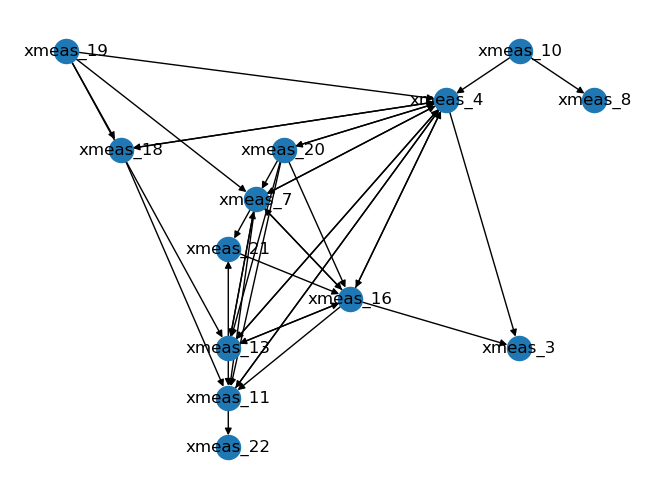

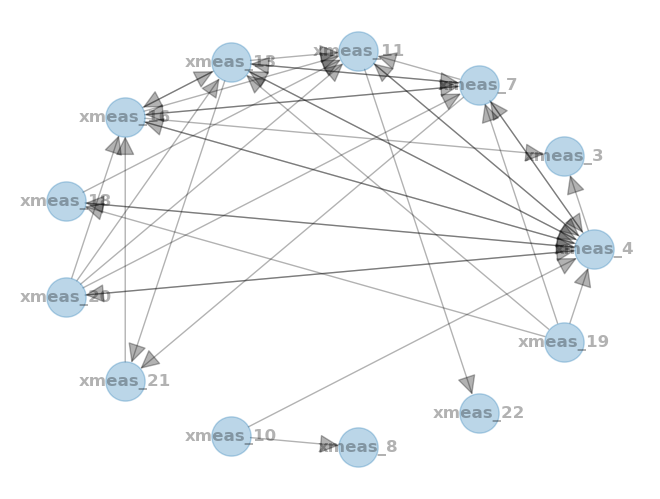

In [21]:
df_train_faulty_alarm = alarm_df(df_train_normal, df_train_faulty)
TETable = transferEntropyTable(df_train_faulty_alarm)
edges = getTableEdges(TETable, feature_list)
G=nx.DiGraph()
nodes = []
for i in edges:
    for j in i:
        if j not in nodes:
            nodes.append(j)
G.add_nodes_from(nodes)
G.add_edges_from(edges)

pos =graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)
plt.show()

nx.draw_circular(
    G, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

In [22]:
# PCA
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA

kComponents = 2
pca = PCA(kComponents)
pca.fit(ss_df_train_normal)

PCA(n_components=2)

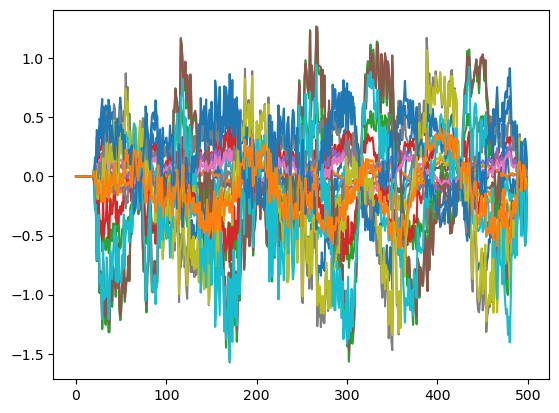

In [21]:
#KPCA
kpca = KernelPCA(n_components=kComponents, kernel='rbf', fit_inverse_transform=True)
'''
x_kpca = kpca.fit_transform(x)
x_reconstructed = kpca.inverse_transform(x_kpca)
residuals = x - x_reconstructed
print(residuals)
#plt.plot(residuals.flatten())
x2 = ss.transform(df_train_faulty,copy=None)
x2_kpca = kpca.transform(x2)
x2_reconstructed = kpca.inverse_transform(x2_kpca)
residuals2 = x2 - x2_reconstructed
plt.plot(residuals2.flatten())
'''
x_faulty = ss.transform(df_train_faulty,copy=None)
x_kpca = kpca.fit(x)
x_fault_free_reconstructed = kpca.inverse_transform(kpca.transform(x))
x_faulty_reconstructed = kpca.inverse_transform(kpca.transform(x_faulty))
residuals = x_fault_free_reconstructed - x_faulty_reconstructed
plt.plot(residuals)

In [80]:
def displayComponentStatistics(data, pca_model, kComponents):
    name = list(df_train_normal.columns)
    score = abs(pca.components_)
    print(sorted(zip(score[0], name), reverse=True)[:kComponents])
    print(sorted(zip(score[1], name), reverse=True)[:kComponents])
    print(np.sum(pca.explained_variance_ratio_[:kComponents]))

def hotelling_t_squared(data, pca_model):
    # Transform data into principal component space
    transformed_data = pca_model.transform(data)
    
    # Calculate centroid in principal component space
    centroid = np.mean(transformed_data, axis=0)
    
    # Calculate Mahalanobis distance (T^2 score) for each sample
    t_squared_scores = np.sum((transformed_data - centroid)**2 / pca_model.explained_variance_, axis=1)
    return t_squared_scores

#doesn't work
def calculate_cdc_score(data, pca_model, faulty_indices):
    # Transform data into principal component space
    transformed_data = pca_model.transform(data)
    
    # Extract relevant components and covariance matrix
    principal_components = pca_model.components_
    covariance_matrix = np.cov(transformed_data.T)
    
    # Calculate CDC scores for each faulty instance and each variable
    cdc_scores = []
    for idx in faulty_indices:
        t_squared_instance = transformed_data[idx]
        cdc_score_instance = np.zeros(len(principal_components))
        for i in range(len(principal_components)):
            contribution = np.dot(principal_components[i], np.dot(np.linalg.inv(covariance_matrix), principal_components[i].T))
            normalized_contribution = contribution / np.sum(contribution)
            cdc_score_instance[i] = normalized_contribution * t_squared_instance[i] ** 2
        cdc_scores.append(cdc_score_instance)
    return np.array(cdc_scores)

def top_ten_vars(df, pca_model):
    name = list(df.columns)
    score = abs(pca_model.components_)
    variables = set()
    for i in sorted(zip(score[0], name), reverse=True)[:5]:
        variables.add(i[1])
    for i in sorted(zip(score[1], name), reverse=True)[:5]:
        variables.add(i[1])
    variables = list(variables)
    return variables

# Freedman-Diaconis rule
def equal_width_bin(df):
    # df = df[df.simulationRun==1].iloc[:,3:25]
    # normalize dataframe
    df = (df - df.mean())/df.std()
    n = df.shape[0]
    for col in list(df.columns):
        c = df[col]
        num_bins = math.ceil((c.max() - c.min()) / (2 * (c.quantile(0.75) - c.quantile(0.25)) / (n**(1/3))))
        df[col] = pd.cut(df[col], bins=num_bins, labels=False)
    return df

#mean contribution threshold
def MCTvariables(contributions, t2_scores):
    # contributions: m x n, where m is number of samples, n is number of variables
    n = len(contributions[0])
    m = len(contributions)
    minFrequency = m * 0.05
    count = [0]*n
    variables = []
    for i in range(m):
        # change 50
        if t2_scores[i] > 50:
            contribution = contributions[i]
            mean = sum(contribution)/n
            for j in range(n):
                if contribution[j] > mean:
                    count[j] += 1
    for i in range(n):
        if count[i] > minFrequency:
            variables.append(i)
    return variables

In [13]:
import numpy as np
from sklearn.neighbors import KernelDensity

def kde_estimate(data, bandwidth=0.2):
    """
    Estimate the probability density function using Gaussian Kernel Density Estimation.

    Parameters:
        data (numpy.ndarray): Array of observations.
        bandwidth (float): Bandwidth of the kernel. Default is 0.2.

    Returns:
        sklearn.neighbors.KernelDensity: Fitted kernel density estimator.
    """
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(data[:, None])
    return kde

def transfer_entropy_kde(x, y, bandwidth=0.2):
    """
    Compute transfer entropy from x to y using Gaussian Kernel Density Estimation.

    Parameters:
        x (array-like): Source time series.
        y (array-like): Target time series.
        bandwidth (float): Bandwidth of the kernel. Default is 0.2.

    Returns:
        float: Transfer entropy from x to y.
    """
    kde_x = kde_estimate(x, bandwidth=bandwidth)
    kde_y = kde_estimate(y, bandwidth=bandwidth)

    n = len(x)
    te = 0
    for i in range(n):
        joint_pdf = np.exp(kde_x.score_samples([[x[i]]]) + kde_y.score_samples([[y[i]]]))
        conditional_pdf = np.exp(kde_x.score_samples([[x[i], y[i]]]))
        te += np.log(conditional_pdf / joint_pdf)

    te /= n
    return te

# Example usage
x = np.random.randn(100)
y = 0.5 * x + np.random.randn(100)
bandwidth = 0.2
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(x[:, None])
print(kde.get_params())
#te_xy_kde = transfer_entropy_kde(x, y, bandwidth=bandwidth)
#print("Transfer entropy from x to y (using KDE):", te_xy_kde)

{'algorithm': 'auto', 'atol': 0, 'bandwidth': 0.2, 'breadth_first': True, 'kernel': 'gaussian', 'leaf_size': 40, 'metric': 'euclidean', 'metric_params': None, 'rtol': 0}


In [83]:
from scipy.stats import chi2

# Obtain the threshold value from the Chi-squared distribution
threshold = chi2.ppf(0.95, kComponents)

print("Threshold for T^2 statistic (95% significance level):", threshold)

Threshold for T^2 statistic (95% significance level): 5.991464547107979


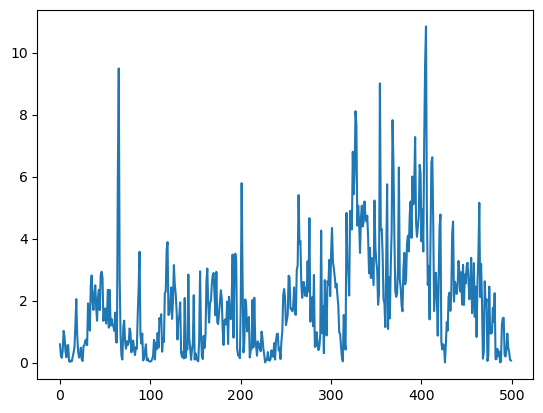

In [23]:
t_squared_scores = hotelling_t_squared(x, pca)
plt.plot(t_squared_scores)

#x_2 = ss.transform(df_train_faulty,copy=None)
#t_squared_scores = hotelling_t_squared(x_2, pca)
#plt.plot(t_squared_scores)

In [47]:
loadings = pca.components_.T
eigenvalues = pca.explained_variance_
hotelling_t2s = np.array([xi.dot(loadings)
                            .dot(np.diag(eigenvalues ** -1))
                            .dot(loadings.T)
                            .dot(xi.T)
                          for xi in x])
t_contribution = np.array([xi.dot(loadings).dot(np.diag(np.sqrt(1/eigenvalues))).dot(loadings.T) for xi in x])
print(t_contribution)

[[ 0.06297357 -0.08151634  0.03300318 ... -0.19730104  0.21189369
  -0.22564172]
 [-0.07705201  0.0405147   0.10286442 ...  0.17110262 -0.10472827
   0.02848409]
 [-0.07178516  0.04475438  0.07888074 ...  0.16772749 -0.11585825
   0.05583957]
 ...
 [ 0.10098838 -0.05616474 -0.12740854 ... -0.22789338  0.14525737
  -0.05014261]
 [ 0.03436822 -0.00931217 -0.06706646 ... -0.06592061  0.02385821
   0.02391335]
 [-0.04851838  0.03238486  0.04814763 ...  0.11590001 -0.08388042
   0.04667147]]
2.782028162197751


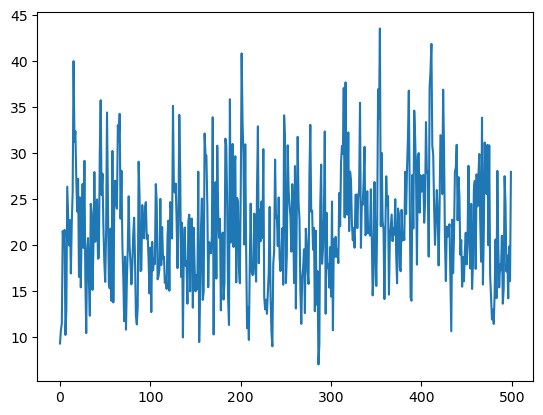

In [22]:
hotelling = HotellingT2().fit(x)
x_t2_scores = hotelling.score_samples(x)
plt.plot(x_t2_scores)

[0, 3, 10, 15, 17, 18, 19]
[0, 3, 6, 10, 12, 15, 17, 18, 19]
[10, 12, 19, 21]


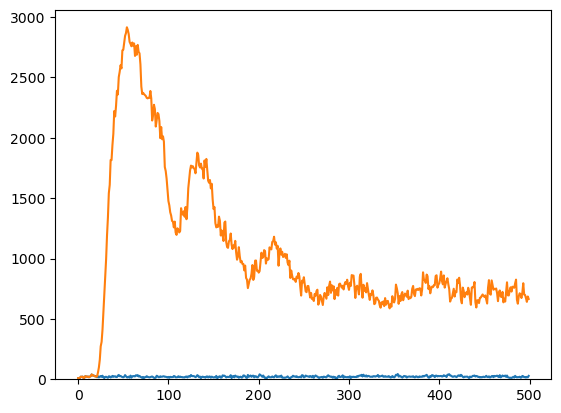

In [125]:
x2 = ss.transform(train_faulty[(train_faulty.simulationRun==1) & (train_faulty.faultNumber==1)].iloc[:,3:25])

hotelling = HotellingT2().fit(x)
x_t2_scores = hotelling.score_samples(x)
plt.plot(x_t2_scores)

t2_scores = hotelling.score_samples(x2)
plt.plot(t2_scores)

myt_dec = MYTDecomposition(hotelling)
uncond_t2_terms = myt_dec.unconditional_t2_terms(x2)
uncond_ucl = myt_dec.ucl_unconditional_terms()
cond_t2_terms = myt_dec.conditional_t2_terms(x2)
cond_ucl = myt_dec.ucl_conditional_terms()
# condition yields less variables, so use condition for now
variables = MCTvariables(cond_t2_terms, t2_scores)
print(MCTvariables(cond_t2_terms, t2_scores))
print(MCTvariables(uncond_t2_terms, t2_scores))

[10, 12, 19, 21]


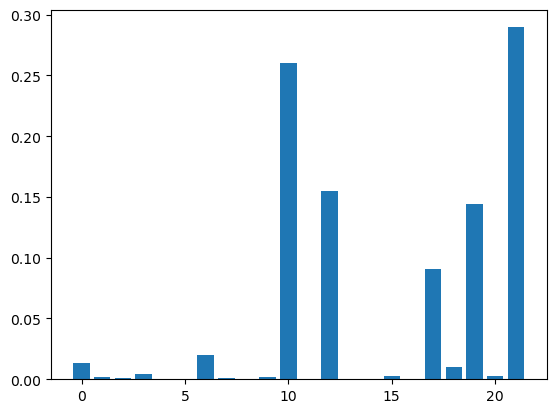

In [124]:
#xgboost DCIG
model = XGBRegressor()
model.fit(x, x_t2_scores)
normalFeatureImportance = model.feature_importances_
model.fit(x_2, t2_scores)
faultyFeatureImportance = model.feature_importances_
diff = abs(faultyFeatureImportance - normalFeatureImportance) / normalFeatureImportance
DCIC = diff / sum(diff)
print([i for i in range(kFeatures) if DCIC[i] > 1/kFeatures])
plt.bar(range(kFeatures),faultyFeatureImportance)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

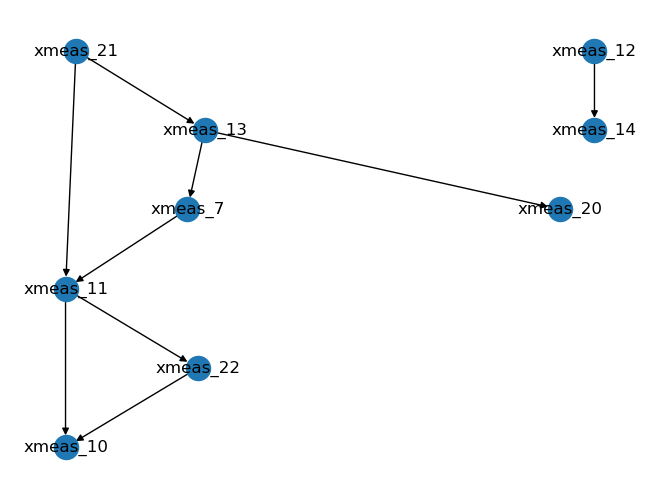

  0%|          | 0/100 [00:00<?, ?it/s]

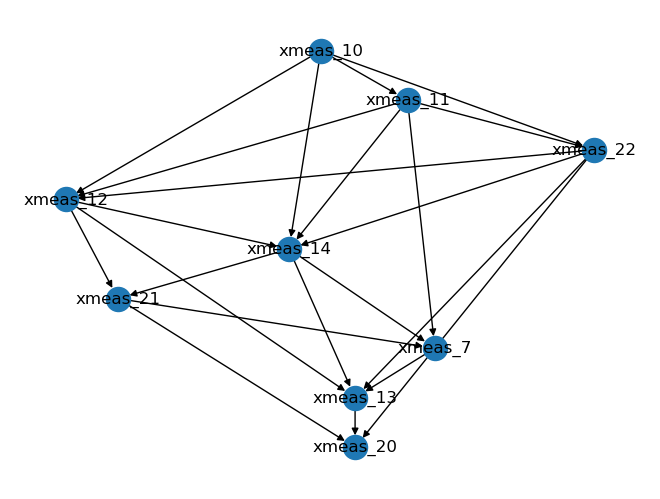

  0%|          | 0/100 [00:00<?, ?it/s]

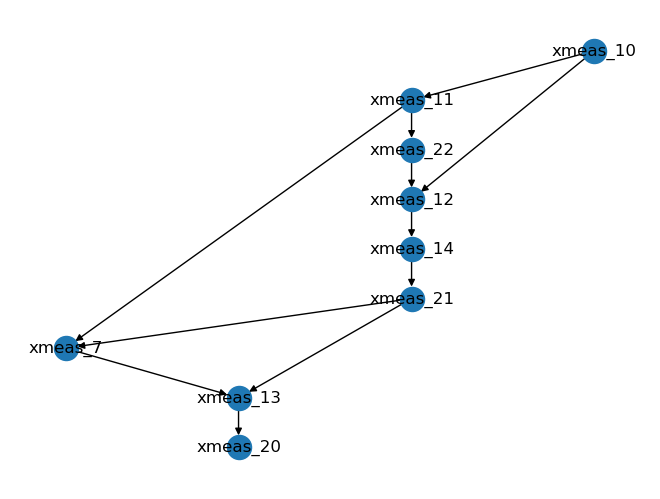

  0%|          | 0/100 [00:00<?, ?it/s]

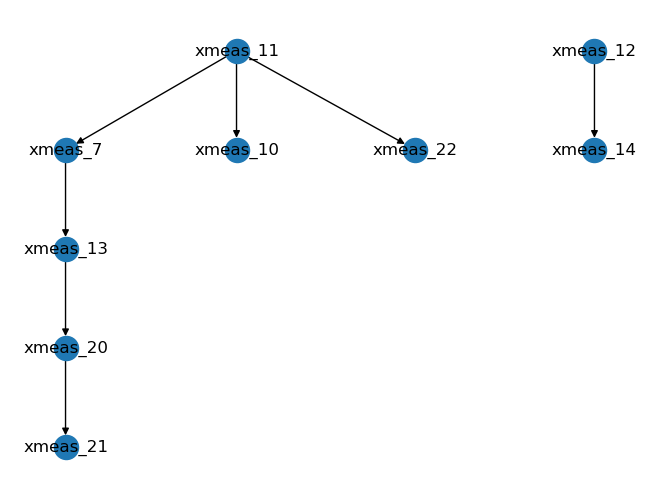

  0%|          | 0/100 [00:00<?, ?it/s]

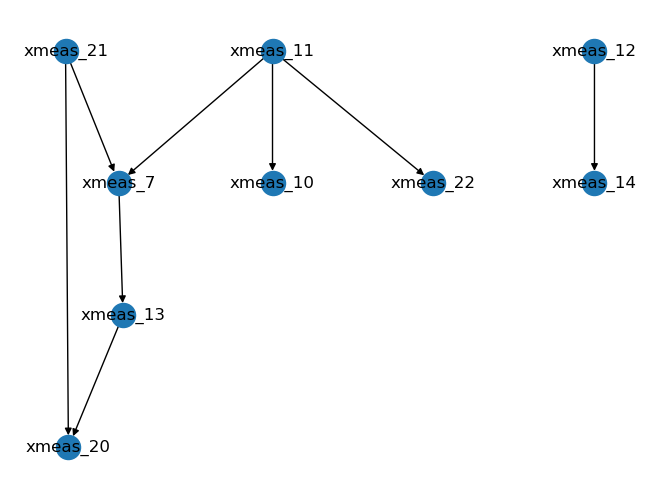

In [70]:
#fault = equal_width_bin(fault)
#fault7 = train_faulty[(train_faulty.simulationRun<10) & (train_faulty.faultNumber==7)]
#variables = ['xmeas_1', 'xmeas_4', 'xmeas_7', 'xmeas_8', 'xmeas_10', 'xmeas_20']
#variables = ['xmeas_9', 'xmeas_18', 'xmeas_20', 'xmeas_22']
#fault7 = equal_width_bin(fault7[variables])
#x2 = ss.transform(df_train_faulty)
fault = alarm_df(df_train_normal, df_train_faulty).loc[:, seperator]
#fault = x2.loc[:, stripper]
#reactor, seperator, stripper

# learn graph structure
est = HillClimbSearch(fault)
# k2score, bdeuscore, bdsscore, bicscore, aicscore
for score in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    best_model = est.estimate(max_iter=100, scoring_method=score, max_indegree=None)
    write_dot(best_model,'test.dot')
    pos =graphviz_layout(best_model, prog='dot')
    nx.draw(best_model, pos, with_labels=True, arrows=True)
    plt.show()

In [45]:
"""
# PC estimator, outputs a very low number of variables
from pgmpy.estimators import PC
est = PC(equal_width_bin(df_train_faulty.iloc[:, variables]))
# 0.001 has 2 edges df_train_normal[variables]
model_chi = est.estimate(significance_level=0.01)
print(len(model_chi.edges()))
nx.draw_circular(
    model_chi, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

# Funtion to evaluate the learned model structures. Not useful since we don't know the actual structure.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_array(
        estimated_model.to_undirected(), nodelist=nodes, weight=None
    )
    true_adj = nx.to_numpy_array(
        true_model.to_undirected(), nodelist=nodes, weight=None
    )

    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)
est = PC(data=df_train_normal)
estimated_model = est.estimate(variant="stable", max_cond_vars=4)
get_f1_score(estimated_model, model)
"""

'\n# Funtion to evaluate the learned model structures. Not useful since we don\'t know the actual structure.\ndef get_f1_score(estimated_model, true_model):\n    nodes = estimated_model.nodes()\n    est_adj = nx.to_numpy_array(\n        estimated_model.to_undirected(), nodelist=nodes, weight=None\n    )\n    true_adj = nx.to_numpy_array(\n        true_model.to_undirected(), nodelist=nodes, weight=None\n    )\n\n    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))\n    print("F1-score for the model skeleton: ", f1)\nest = PC(data=df_train_normal)\nestimated_model = est.estimate(variant="stable", max_cond_vars=4)\nget_f1_score(estimated_model, model)\n'

algorithm: CAM
time elpased: 2.0196945667266846
algorithm: CCDr
time elpased: 1.1012718677520752
algorithm: GES
time elpased: 0.8000845909118652
algorithm: GIES
time elpased: 0.8049359321594238
algorithm: LiNGAM
time elpased: 0.8503768444061279
algorithm: PC
time elpased: 1.916764736175537


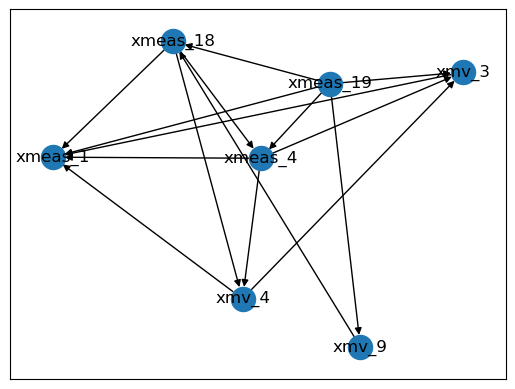

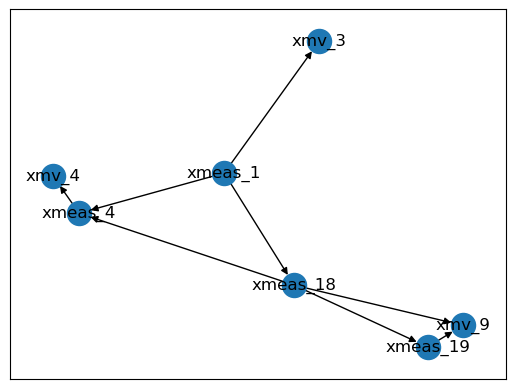

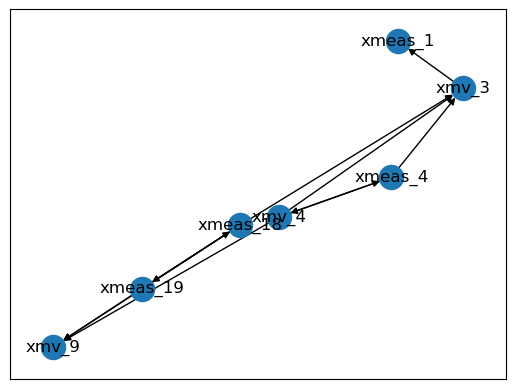

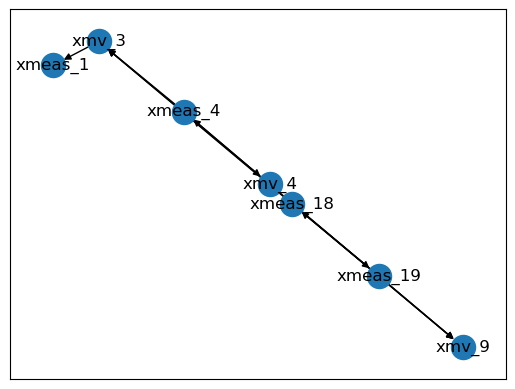

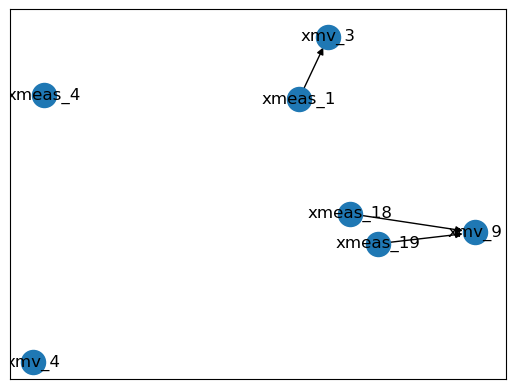

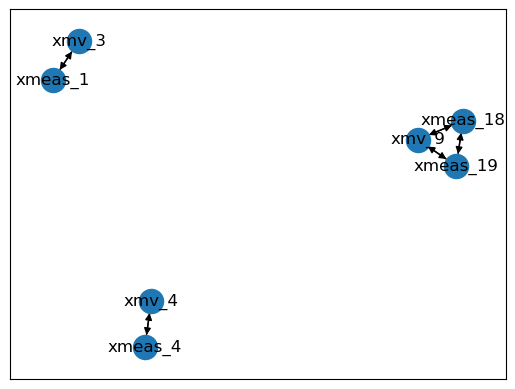

In [18]:
algorithms = [ cdt.causality.graph.CAM() # 2 mins
             , cdt.causality.graph.CCDr()
             , cdt.causality.graph.GES()
             , cdt.causality.graph.GIES()
             , cdt.causality.graph.LiNGAM()
             , cdt.causality.graph.PC()]
nalgo = len(algorithms)
for i in range(nalgo):
    algo = str(algorithms[i]).split(sep='.')[3]
    print("algorithm:", algo)
    start = time.time()
    g = algorithms[i].predict(fault7)
    end = time.time()
    print("time elpased:", end - start)
    plt.figure(algo)
    nx.draw_networkx(g, with_labels=True)
plt.show()

In [51]:
from pgmpy.estimators import BayesianEstimator

# there are many choices of parametrization, here is one example
model = BayesianNetwork(dag.edges())
model.fit(
    df_train_normal, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts=0.1
)
model.get_cpds()

[<TabularCPD representing P(xmeas_1:482) at 0x1db1432ef50>,
 <TabularCPD representing P(xmv_7:490 | xmeas_1:482) at 0x1db14600a50>,
 <TabularCPD representing P(xmv_8:490 | xmv_7:490) at 0x1db149049d0>,
 <TabularCPD representing P(xmv_3:488 | xmv_7:490) at 0x1db149076d0>,
 <TabularCPD representing P(xmv_11:479 | xmv_7:490) at 0x1db149048d0>,
 <TabularCPD representing P(xmv_6:473 | xmv_7:490) at 0x1db14905650>,
 <TabularCPD representing P(xmeas_12:462 | xmv_7:490) at 0x1db14905750>,
 <TabularCPD representing P(xmv_4:471 | xmv_7:490) at 0x1db14905b90>,
 <TabularCPD representing P(xmeas_10:462 | xmv_7:490) at 0x1db14906050>,
 <TabularCPD representing P(xmeas_4:460 | xmv_7:490) at 0x1db149062d0>,
 <TabularCPD representing P(xmeas_14:455 | xmv_7:490) at 0x1db149065d0>,
 <TabularCPD representing P(xmeas_17:451 | xmv_7:490) at 0x1db14906990>,
 <TabularCPD representing P(xmv_10:446 | xmv_7:490) at 0x1db14906d90>,
 <TabularCPD representing P(xmeas_8:441 | xmv_7:490) at 0x1db14907450>,
 <TabularC

In [52]:
# Analyse distribution of variables, e.g. normally distributed with normality test like Anderson-Darling Test
from scipy.stats import anderson

# Create header for tabular output
print(f"{'DISTRIBUTION':<15}{'%sig':<10}{'stat':<12}{'crit-val':<10}"
      f"{'result':<10}\n")

# Loop through all continuous random variables and test them
for var in df_train_normal.columns:
    test = anderson(df_train_normal[var])
    # Loop through test results and unpack the sig.levels and crit-vals
    for i in range(len(test.critical_values)):
        sig_lev, cv = test.significance_level[i], test.critical_values[i]
        # Check if test.stat is < crit-val
        result = 'Fail to reject' if test.statistic < cv else 'Reject'
        # Print results in tabular format
        print(f"{var:<15}{sig_lev:<10}{test.statistic:<12.3f}{cv:<10}"
              f"{result:<10}")  
        if i is 4:
            print('\n')

DISTRIBUTION   %sig      stat        crit-val  result    

xmeas_1        15.0      0.661       0.571     Reject    
xmeas_1        10.0      0.661       0.651     Reject    
xmeas_1        5.0       0.661       0.781     Fail to reject
xmeas_1        2.5       0.661       0.911     Fail to reject
xmeas_1        1.0       0.661       1.083     Fail to reject


xmeas_2        15.0      0.634       0.571     Reject    
xmeas_2        10.0      0.634       0.651     Fail to reject
xmeas_2        5.0       0.634       0.781     Fail to reject
xmeas_2        2.5       0.634       0.911     Fail to reject
xmeas_2        1.0       0.634       1.083     Fail to reject


xmeas_3        15.0      0.828       0.571     Reject    
xmeas_3        10.0      0.828       0.651     Reject    
xmeas_3        5.0       0.828       0.781     Reject    
xmeas_3        2.5       0.828       0.911     Fail to reject
xmeas_3        1.0       0.828       1.083     Fail to reject


xmeas_4        15.0      0.33

<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\paulo\AppData\Local\Temp\ipykernel_6696\859025840.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 4:


In [23]:
import pysmile
# pysmile_license is your license key
import pysmile_license

def hello_smile():
    net = pysmile.Network()
    net.read_file("VentureBN.xdsl");
    net.set_evidence("Forecast", "Moderate")
    net.update_beliefs()
    beliefs = net.get_node_value("Success")
    for i in range(0, len(beliefs)):
        print(net.get_outcome_id("Success", i) + "=" + str(beliefs[i]))
        


Success=0.25000000000000006
Failure=0.75


In [32]:
def create_cpt_node(net, id, name, outcomes, x_pos, y_pos):
    handle = net.add_node(pysmile.NodeType.CPT, id)
    net.set_node_name(handle, name)
    net.set_node_position(handle, x_pos, y_pos, 85, 55)
    initial_outcome_count = net.get_outcome_count(handle)
    for i in range(0, initial_outcome_count):
        net.set_outcome_id(handle, i, outcomes[i])
    for i in range(initial_outcome_count, len(outcomes)):
        net.add_outcome(handle, outcomes[i])    
    return handle

def print_posteriors(net, node_handle):
    node_id = net.get_node_id(node_handle)
    if net.is_evidence(node_handle):      
        print(f"{node_id} has evidence set ({net.get_evidence_id(node_handle)})") 
    else :           
        posteriors = net.get_node_value(node_handle)           
        for i in range(0, len(posteriors)):               
            print(f"P({node_id}={net.get_outcome_id(node_handle, i)})={posteriors[i]}")    

def print_all_posteriors(net):        
    for handle in net.get_all_nodes():            
        print_posteriors(net, handle)        
        
def change_evidence_and_update(net, node_id, outcome_id):        
    if outcome_id is not None:           
        net.set_evidence(node_id, outcome_id)       
    else:            
        net.clear_evidence(node_id)        
    net.update_beliefs()        
    print_all_posteriors(net)        
    print()
    
net = pysmile.Network()
e = create_cpt_node(net,    "Economy", "State of the economy",    ["Up","Flat","Down"],     160, 40)
s = create_cpt_node(net,    "Success", "Success of the venture",    ["Success","Failure"],     60, 40)
f = create_cpt_node(net,    "Forecast", "Expert forecast",    ["Good","Moderate","Poor"],     110, 140)
net.add_arc(e, s)
net.add_arc(s, f)
net.add_arc("Economy", "Forecast")

economyDef = [            0.2, # P(Economy=U)
              0.7, # P(Economy=F)   
              0.1  # P(Economy=D) 
             ]        
net.set_node_definition(e, economyDef)

successDef = [    0.3, # P(Success=S|Economy=U)
              0.7, # P(Success=F|Economy=U)
              0.2, # P(Success=S|Economy=F)
              0.8, # P(Success=F|Economy=F)
              0.1, # P(Success=S|Economy=D) 
              0.9  # P(Success=F|Economy=D) 
             ]
net.set_node_definition(s, successDef)

forecastDef = [            0.70, # P(Forecast=G|Success=S,Economy=U) 
               0.29, # P(Forecast=M|Success=S,Economy=U)      
               0.01, # P(Forecast=P|Success=S,Economy=U)    
               0.65, # P(Forecast=G|Success=S,Economy=F)      
               0.30, # P(Forecast=M|Success=S,Economy=F)        
               0.05, # P(Forecast=P|Success=S,Economy=F)      
               0.60, # P(Forecast=G|Success=S,Economy=D)       
               0.30, # P(Forecast=M|Success=S,Economy=D)       
               0.10, # P(Forecast=P|Success=S,Economy=D)      
               0.15,  # P(Forecast=G|Success=F,Economy=U)    
               0.30, # P(Forecast=M|Success=F,Economy=U)     
               0.55, # P(Forecast=P|Success=F,Economy=U)     
               0.10, # P(Forecast=G|Success=F,Economy=F)     
               0.30, # P(Forecast=M|Success=F,Economy=F)      
               0.60, # P(Forecast=P|Success=F,Economy=F)     
               0.05, # P(Forecast=G|Success=F,Economy=D)
               0.25, # P(Forecast=G|Success=F,Economy=D) 
               0.70  # P(Forecast=G|Success=F,Economy=D)   
              ]       
net.set_node_definition(f, forecastDef)

print("Posteriors with no evidence set:")
net.update_beliefs()
print_all_posteriors(net)
change_evidence_and_update(net, "Forecast", "Poor")

Posteriors with no evidence set:
P(Economy=Up)=0.20000000000000004
P(Economy=Flat)=0.7000000000000001
P(Economy=Down)=0.10000000000000002
P(Success=Success)=0.21000000000000002
P(Success=Failure)=0.79
P(Forecast=Good)=0.2205
P(Forecast=Moderate)=0.2949
P(Forecast=Poor)=0.4846
P(Economy=Up)=0.1601320676846884
P(Economy=Flat)=0.7078002476269087
P(Economy=Down)=0.13206768468840283
P(Success=Success)=0.01774659513000413
P(Success=Failure)=0.9822534048699959
Forecast has evidence set (Poor)

